<a href="https://colab.research.google.com/github/Eviyak/News-Headlines-Source-Classifier/blob/main/%D0%90%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7%D0%B0%D1%82%D0%BE%D1%80_%D0%B7%D0%B0%D0%B3%D0%BE%D0%BB%D0%BE%D0%B2%D0%BA%D0%BE%D0%B2_%D0%A1%D0%9C%D0%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

def parse_rss(url, source_name, limit=None):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'xml')
    items = soup.find_all('item')
    titles = [item.title.text for item in items]

    if limit:
        titles = titles[:limit]

    return pd.DataFrame({'title': titles, 'source': source_name})


df_ria = parse_rss("https://ria.ru/export/rss2/archive/index.xml", "RIA", limit=100)
df_tass = parse_rss("https://tass.ru/rss/v2.xml", "TASS", limit=100)

df_all = pd.concat([df_ria, df_tass], ignore_index=True)


df_all.to_csv("news_titles_combined.csv", index=False)

print(df_all.sample(10))


                                                 title source
165  В Новороссийске объявили угрозу применения без...   TASS
79   Захарова рассказала, чего хочет Зеленский, тре...    RIA
3    В нескольких областях Украины объявили воздушн...    RIA
181  Медведев считает, что Рютте объелся грибов с е...   TASS
47                       В Николаеве прогремели взрывы    RIA
171  На Балтийском флоте прошли учения по отражению...   TASS
135  В Орловской области объявили авиационную опасн...   TASS
67   Путин примет участие в награждении волонтеров,...    RIA
109  Al Jazeera: в Газе при ударах Израиля за сутки...   TASS
36   В Иране зафиксировали серьезное нарушение подк...    RIA


In [ ]:
df_all['word_count'] = df_all['title'].apply(lambda x: len(x.split()))
df_all.groupby('source')['word_count'].mean()

,word_count
source,
RIA,7.767677
TASS,9.420000


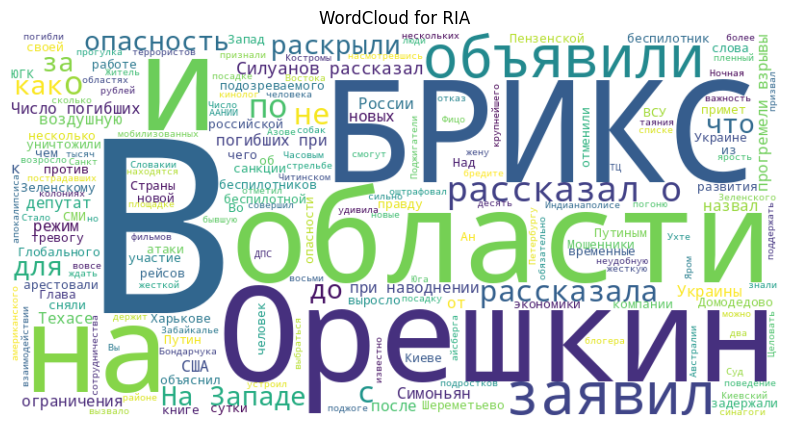

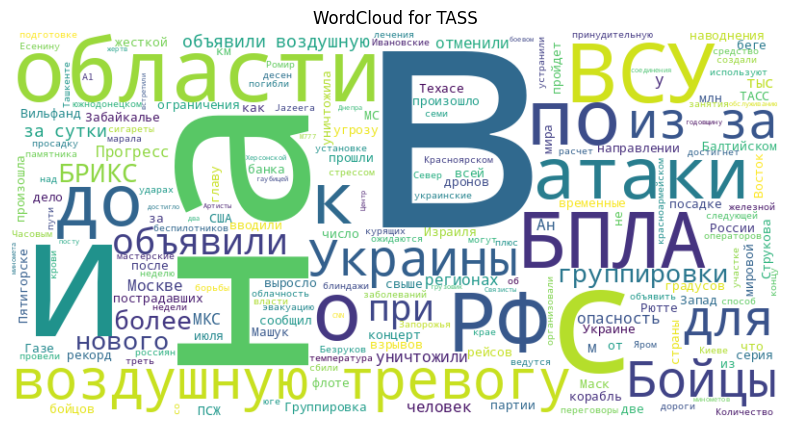

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for source in df_all['source'].unique():
    text = ' '.join(df_all[df_all['source'] == source]['title'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud for {source}')
    plt.show()


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X = df_all['title']
y = df_all['source']

vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         RIA       0.70      0.67      0.68        21
        TASS       0.65      0.68      0.67        19

    accuracy                           0.68        40
   macro avg       0.68      0.68      0.67        40
weighted avg       0.68      0.68      0.68        40



In [ ]:
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.675
